<div style="width: 100%; overflow: hidden; text-align:center;">
    <h1>INF-477 Redes Neuronales Artificiales</h1>
    <h2>Tarea 3 - Redes Neuronales Recurrentes</h2><br/>
    <div style="width: 50%; float: left;">
        <h3>Gabriel Jara</h3>
        <h4>``gabriel.jara@usm.cl``</h4>
        <h4>13550188-3</h4>
    </div>
    <div style="margin-left: 300px;">
        <h3>Daniel San Martín</h3>
        <h4>``daniel.sanmartinr@sansano.usm.cl``</h4>
        <h4>682016101-5</h4>
    </div>
</div>

## Análisis de sentimientos usando RNN

Las redes recurrentes son utilizadas también en procesamiento de lenguaje natural. En esta ocasión usaremos
el *Large Movie Review Dataset*, también conocido como *IMDB dataset* que contiene 50000 comentarios de películas etiquetadas como buenas o malas (50 %-50 % train-testing). El problema consiste en procesar el texto contenido en un comentario para determinar si este es positivo o negativo. Este dataset fue recolectado por investigadores de Stanford [5] y utilizado en la competencia Kaggle [6].

<img src="img/figure2.png" />
<center>Figura 2: IMDB dataset</center>

(a) Cargue el dataset completo

In [1]:
import numpy as np
from keras.datasets import imdb
from theano.tensor.shared_randomstreams import RandomStreams
np.random.seed(15)
srng = RandomStreams(8)

(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)

Using Theano backend.
Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)


(b) Concatene los conjuntos de entrenamiento. ¿Cuántas palabras tiene el dataset? Obtenga un boxplot de la distribución del largo de las palabras. Comente.

Review length: 


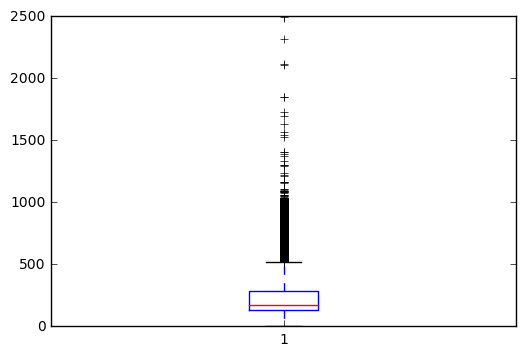

El data set completo tiene 11737946 palabras, distribuidas en 88455 términos diferentes.
Las reseñas tienen en promedio 234.75892 palabras, con desviación estándar de 172.911494587.


In [2]:
from itertools import chain

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

from matplotlib import pyplot

print("Review length: ")
result = map(len, X)
pyplot.boxplot(result)
pyplot.show()

print 'El data set completo tiene '+ str(len(list(chain.from_iterable(X))))+ ' palabras, distribuidas en ' +str(max(np.amax(X)))+' términos diferentes.'
print 'Las reseñas tienen en promedio '+str(np.mean(result))+' palabras, con desviación estándar de '+str(np.std(result))+'.'

(c) Cargue nuevamente el dataset, pero esta vez extrayendo solo las 3000 palabras más relevantes y acotando el largo máximo para un comentario en 500 palabras. Los comentarios con un largo menor deben ser rellenados con 0 para que la red reciba todas los ejemplos del mismo tamaño.

In [3]:
from keras.preprocessing import sequence

top_words = 3000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

pred_x_train = np.zeros(shape=(len(X_train),1))
pred_x_test = np.zeros(shape=(len(X_test),1))

(d) Entrene una red LSTM con una capa de embedding y evalúe su desempeño.

Dado que se ha observado que, al menos en la implementación de Keras, las LSTM presentan un alto grado de variabilidad que no logra ser controlada, es que se ha optado por repetir los próximos experimentos en grupos de 5. Para cada configuración se ejecutará 5 veces, luego de lo cual se procederá a obtener la Accuracy media e Intervalo de Confianza de la misma, esto último utilizando test t-student en consideración a lo imitado del tamaño de muestra. Además, para cada modelo constrido se almacenrará las predicciones tanto sobre el training set como sobre el test set, a fin de utilizarlo al final en un stacking de todos los modelos. 

A continuación se declara la función que se utilizará para obtener los intervalos de confianza. 

In [4]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t.ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

A continuación se entrena y evalua una red de una capa LSTM de 100 nodos, utilizando función de activación sigmoid, sobre las 3000 palabras más frecuentes vector de embedding de largo 32. Como ya se ha mencionado, se entrenará y evaluará esta configuración en 5 ocasiones, para obtener la exactitud media e intervalo de confianza. 

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = 32

K = 5
score = [None]*K

for k in range(0,K):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=500))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    score[k] = model.evaluate(X_test, y_test, verbose=0)
    print  "[loss , accuracy] : " + str(score[k])
    print " "
    pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
    pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
    indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2' 
    pred_indice = [indice]
    print 'Guardado como: '+str(indice)
    print ' '
ci = mean_confidence_interval(np.transpose(score)[1])
print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
print ' '

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 379s - loss: 0.4748 - acc: 0.7690 - val_loss: 0.3946 - val_acc: 0.8241
Epoch 2/3
25000/25000 [==============================] - 372s - loss: 0.3120 - acc: 0.8723 - val_loss: 0.3099 - val_acc: 0.8696
Epoch 3/3
25000/25000 [==============================] - 349s - loss: 0.3027 - acc: 0.8796 - val_loss: 0.3240 - val_acc: 0.8639
[loss , accuracy] : [0.32396760501146316, 0.86392000000000002]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 362s - loss: 0.5193 - acc: 0.7536 - val_loss: 0.4184 - val_acc: 0.8142
Epoch 2/3
25000/25000 [==============================] - 363s - loss: 0.3120 - acc: 0.8723 - val_loss: 0.3018 - val_acc: 0.8770
Epoch 3/3
25000/25000 [==============================] - 347s - loss: 0.2698 - acc: 0.8922 - val_loss: 0.2955

Se aprecia en que la excatitud alcanza en promedio 0.872. Se puede establecer con un 97.5% de confianza, ademas, que con esta configuración otros cinco experimentos obtendrían una media promedio igual o superior a 0.864. 

(e) Varíe el tamaño del vector generado por el embedding. Comente.

Las redes neuronales con nodos LSTM rescatan no solo palabras independientemente, sino conceptos implicitos en el texto, para lo cual aprovechan la técnica de Embedding, consistente en mapear palabras o frases a un vector numérico. Cada observación se reduce entonces a un vector de largo fijo, de acuerdo al mapeo de embedding resultante del entrenamiento. En este caso se probará distintas configuraciones para el largo de dicho vector, siempre bajo la modalidad de 5 experimentos por configuración. 

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = [8, 32, 64]

K = 5
scores_lb = [None]*len(embedding_vector_length)
scores_me = [None]*len(embedding_vector_length)
score = [None]*K



for i in range(0,len(embedding_vector_length)):
    for k in range(0,K):
        model = Sequential()
        model.add(Embedding(top_words, embedding_vector_length[i], input_length=500))
        model.add(LSTM(100))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
        score[k] = model.evaluate(X_test, y_test, verbose=0)
        print "[loss , accuracy] con vector de " + str(embedding_vector_length[i]) + ": " + str(score[k])
        print " "
        pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
        pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
        indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl' + str(embedding_vector_length[i]) + ' - sigmoid - binary - adam'
        pred_indice = [pred_indice , indice]
        print 'Guardado como: '+str(indice)
        print ' '
    ci = mean_confidence_interval(np.transpose(score)[1])
    print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
    print ' '
    scores_me[i] = ci[0]
    scores_lb[i] = ci[1]
for i in range(0,len(embedding_vector_length)):
    print 'Embedding: '+ str(embedding_vector_length[i]) + ' => Accuracy media:'+ str(scores_me[i]) +' , mayor que: ' + str(scores_lb[i])
    print ' '

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 347s - loss: 0.6422 - acc: 0.6067 - val_loss: 0.4141 - val_acc: 0.8202
Epoch 2/3
25000/25000 [==============================] - 347s - loss: 0.3820 - acc: 0.8357 - val_loss: 0.3893 - val_acc: 0.8347
Epoch 3/3
25000/25000 [==============================] - 339s - loss: 0.3514 - acc: 0.8533 - val_loss: 0.4009 - val_acc: 0.8240
[loss , accuracy] con vector de 8: [0.40088018536567688, 0.82399999999999995]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl8 - sigmoid - binary - adam
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 340s - loss: 0.5184 - acc: 0.7414 - val_loss: 0.3522 - val_acc: 0.8506
Epoch 2/3
25000/25000 [==============================] - 340s - loss: 0.3215 - acc: 0.8696 - val_loss: 0.4521 - val_acc: 0.7864
Epoch 3/3
25000/25000 [==============================] - 340s - loss: 0.3481 - acc: 0.8480 - val_loss: 0.

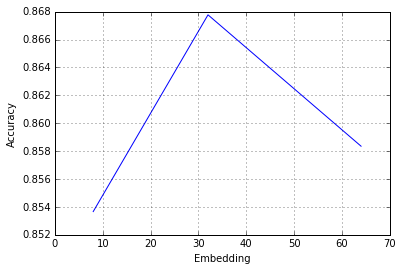

In [2]:
import matplotlib.pyplot as plt
import numpy as np

emb = np.array([8, 32, 64])
acc = np.array([0.853664, 0.867768, 0.858352])

plt.plot(emb, acc)
plt.grid(True)
plt.xlabel("Embedding")
plt.ylabel("Accuracy")
plt.show()

El resultado del experimento indicaría que aumentar el embedding en princio mejora la capacidad del modelo, pero existe un tamaño ideal por sobre el cual la estimación en el test set empeora, probablemente debido a sobreajuste. 

(f) Repita el proceso cambiando el número de palabras top seleccionadas.

A continuación lo mismo, pero variando el número de palabras más frecuentes que se tomará en cuenta en el analisis. 

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = [1000, 3000, 6000]
embedding_vector_length = 32

K = 5
scores_lb = [None]*len(top_words)
scores_me = [None]*len(top_words)
score = [None]*K

for i in range(0,len(top_words)):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words[i], seed=15)
    X_train = sequence.pad_sequences(X_train, maxlen=500)
    X_test = sequence.pad_sequences(X_test, maxlen=500)
    for k in range(0,K):    
        model = Sequential()
        model.add(Embedding(top_words[i], embedding_vector_length, input_length=500))
        model.add(LSTM(100))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
        score[k] = model.evaluate(X_test, y_test, verbose=0)
        print  "[loss , accuracy] con " + str(top_words[i]) + " palabras: " + str(score[k])
        print " "
        pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
        pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
        indice = 'k= ' + str(k) + ' - LSTM100 - top' + str(top_words[i]) +' - evl32 - sigmoid - binary - adam'
        pred_indice = [pred_indice , indice]
        print 'Guardado como: '+str(indice)
        print ' '
    ci = mean_confidence_interval(np.transpose(score)[1])
    print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
    print ' '
    scores_me[i] = ci[0]
    scores_lb[i] = ci[1]
for i in range(0,len(top_words)):
    print 'Top Words: '+ str(top_words[i]) + ' => Accuracy media:'+ str(scores_me[i]) +' , mayor que: ' + str(scores_lb[i])
    print ' '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 347s - loss: 0.5199 - acc: 0.7302 - val_loss: 0.4144 - val_acc: 0.8142
Epoch 2/3
25000/25000 [==============================] - 346s - loss: 0.3627 - acc: 0.8466 - val_loss: 0.3387 - val_acc: 0.8571
Epoch 3/3
25000/25000 [==============================] - 347s - loss: 0.3394 - acc: 0.8587 - val_loss: 0.3617 - val_acc: 0.8478
[loss , accuracy] con 1000 palabras: [0.36169387331008912, 0.84784000000000004]
 
Guardado como: k= 0 - LSTM100 - top1000 - evl32 - sigmoid - binary - adam
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 345s - loss: 0.5142 - acc: 0.7396 - val_loss: 0.3896 - val_acc: 0.8314
Epoch 2/3
25000/25000 [==============================] - 350s - loss: 0.5055 - acc: 0.7566 - val_loss: 0.4534 - val_acc: 0.7910
Epoch 3/3
25000/25000 [==============================] - 347s - loss: 0.5657 - acc: 0.7046 - val_loss:

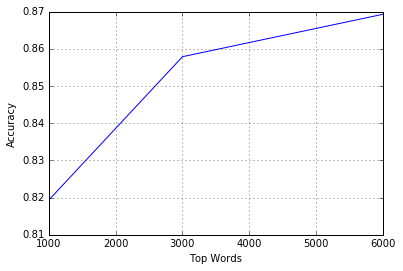

In [4]:
import matplotlib.pyplot as plt
import numpy as np

words = np.array([1000, 3000, 6000])
acc = np.array([0.819272, 0.85788, 0.869304])

plt.plot(words, acc)
plt.grid(True)
plt.xlabel("Top Words")
plt.ylabel("Accuracy")
plt.show()

El experimento realizado indica que aumentar el número de palabras más frecuentes activas para efectos de análisis, ayuda a mejorar los resultados. Al menos en el límite de palabras seleccionadas en este caso, que fueron 6000, no hay aún señales de sobreajuste del modelo.

Pese a lo anterior, con fin de mantener la comparación, los siguientes experimentos se mantendrán con la configuración inicial de 3000 palabras. 

(g) Use dropout para entrenar la LSTM. ¿El dropout mejora el desempeño de la red? Señale cuales podrían ser las causas del comportamiento observado.

A continuación se probará la tecnica de regularización denominada Dropout, que consiste en desactivar con alguna probabilidad cada nodo, durante el proceso de entrenamiento, forzando a la red a encontrar soluciones más generales. Se probará distintas configuraciones de probabilidad de activar cada nodos. 

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = 32
dropout = [0.1, 0.2, 0.5]

K = 5
scores_lb = [None]*len(dropout)
scores_me = [None]*len(dropout)
score = [None]*K

for i in range(0,len(dropout)):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, seed=15)
    X_train = sequence.pad_sequences(X_train, maxlen=500)
    X_test = sequence.pad_sequences(X_test, maxlen=500)
    for k in range(0,K):
        model = Sequential()
        model.add(Embedding(top_words, embedding_vector_length, input_length=500))
        model.add(Dropout(dropout[i]))
        model.add(LSTM(100))
        model.add(Dropout(dropout[i]))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
        score[k] = model.evaluate(X_test, y_test, verbose=0)
        print  "[loss , accuracy] con Dropout: " + str(dropout[i]) + ": " + str(score[k])
        print " "
        pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
        pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
        indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl32 - sigmoid - binary - adam - dropout' + str(dropout[i])
        pred_indice = [pred_indice , indice]
        print 'Guardado como: '+str(indice)
        print ' '
    ci = mean_confidence_interval(np.transpose(score)[1])
    print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
    print ' '
    scores_me[i] = ci[0]
    scores_lb[i] = ci[1]
for i in range(0,len(dropout)):
    print 'Dropout: '+ str(dropout[i]) + ' => Accuracy media:'+ str(scores_me[i]) +' , mayor que: ' + str(scores_lb[i])
    print ' '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 353s - loss: 0.5331 - acc: 0.7232 - val_loss: 0.3606 - val_acc: 0.8508
Epoch 2/3
25000/25000 [==============================] - 350s - loss: 0.3214 - acc: 0.8695 - val_loss: 0.3103 - val_acc: 0.8730
Epoch 3/3
25000/25000 [==============================] - 349s - loss: 0.2664 - acc: 0.8931 - val_loss: 0.3163 - val_acc: 0.8726
[loss , accuracy] con Dropout: 0.1: [0.31628254446268084, 0.87263999999999997]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl32 - sigmoid - binary - adam - dropout0.1
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 348s - loss: 0.4955 - acc: 0.7531 - val_loss: 0.3728 - val_acc: 0.8515
Epoch 2/3
25000/25000 [==============================] - 347s - loss: 0.3258 - acc: 0.8650 - val_loss: 0.3337 - val_acc: 0.8598
Epoch 3/3
25000/25000 [==============================] - 348s - loss: 0.2892 - acc: 0.8858

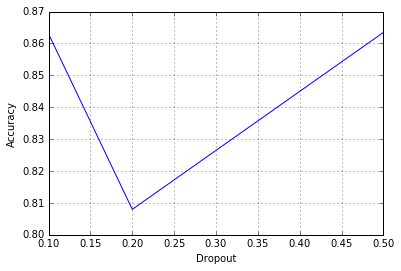

In [7]:
import matplotlib.pyplot as plt
import numpy as np

drop = np.array([0.1, 0.2, 0.5])
acc = np.array([0.863, 0.807976, 0.863472])

plt.plot(drop, acc)
plt.grid(True)
plt.xlabel("Dropout")
plt.ylabel("Accuracy")
plt.show()

Los resultados con Dropout resultaron peores que sin esta técnica, y además se observa cierta inestabilidad, puesto que uno de los 15 experimentos realizados obtuvo una precisión mucho más baja que el resto. Esto se puede deber a que, en la configuración original del experimento, no se presenta sobreajuste. 

En los siguientes experimentos, donde se profundiza la red, se mantendrá un Dropout moderado como medida de mitigación de eventual sobreajuste. 

(h) Proponga un modelo que rebaje el error de test respecto de los modelos estudiados anteriormente.

Se probará en primer lugar modificar la función de activación por ReLu. 

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = 32
dropout = 0.5

K = 5
score = [None]*K

for k in range(0,K):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=500))
    model.add(Dropout(dropout))
    model.add(LSTM(100))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    score[k] = model.evaluate(X_test, y_test, verbose=0)
    print  "[loss , accuracy] con ReLu: " + str(score[k])
    print " "
    pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
    pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
    indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2' 
    pred_indice = [pred_indice , indice]
    print 'Guardado como: '+str(indice)
    print ' '
ci = mean_confidence_interval(np.transpose(score)[1])
print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
print ' '

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 350s - loss: 0.6296 - acc: 0.6616 - val_loss: 0.4405 - val_acc: 0.8141
Epoch 2/3
25000/25000 [==============================] - 350s - loss: 0.5368 - acc: 0.7606 - val_loss: 0.4375 - val_acc: 0.8243
Epoch 3/3
25000/25000 [==============================] - 350s - loss: 0.4462 - acc: 0.8164 - val_loss: 0.4361 - val_acc: 0.8435
[loss , accuracy] con ReLu: [0.43611673567771914, 0.84348000000000001]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 361s - loss: 0.6349 - acc: 0.6764 - val_loss: 0.4664 - val_acc: 0.7930
Epoch 2/3
25000/25000 [==============================] - 365s - loss: 0.5103 - acc: 0.7771 - val_loss: 0.4965 - val_acc: 0.7897
Epoch 3/3
25000/25000 [==============================] - 386s - loss: 0.5330 - acc: 0.7549 - val_loss

Se observa que, en este caso, cambiar la función de activación empeoró los resultados de los modelos. 

El siguiente experimento vuelve a la configuración inicial, con sigmoid, a lo que se agrega una capa más de profundidad, de 200 nodos. Esta capa adicional no es LSTM. 

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = 32
dropout = 0.5

K = 5
score = [None]*K

for k in range(0,K):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=500))
    model.add(Dropout(dropout))
    model.add(LSTM(100))
    model.add(Dropout(dropout))
    model.add(Dense(200, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    score[k] = model.evaluate(X_test, y_test, verbose=0)
    print  "[loss , accuracy] con ReLu: " + str(score[k])
    print " "
    pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
    pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
    indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl32 - sigmoid - binary - adam - dropout0.2 - deep2' 
    pred_indice = [pred_indice , indice]
    print 'Guardado como: '+str(indice)
    print ' '
ci = mean_confidence_interval(np.transpose(score)[1])
print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
print ' '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 361s - loss: 0.5565 - acc: 0.6936 - val_loss: 0.4002 - val_acc: 0.8205
Epoch 2/3
25000/25000 [==============================] - 361s - loss: 0.3413 - acc: 0.8608 - val_loss: 0.3249 - val_acc: 0.8682
Epoch 3/3
25000/25000 [==============================] - 357s - loss: 0.2845 - acc: 0.8861 - val_loss: 0.2973 - val_acc: 0.8735
[loss , accuracy] con ReLu: [0.29734419645547866, 0.87348000000000003]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl32 - sigmoid - binary - adam - dropout0.2 - deep2
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 350s - loss: 0.4799 - acc: 0.7488 - val_loss: 0.3309 - val_acc: 0.8585
Epoch 2/3
25000/25000 [==============================] - 349s - loss: 0.3312 - acc: 0.8648 - val_loss: 0.3340 - val_acc: 0.8628
Epoch 3/3
25000/25000 [==============================] - 351s - loss: 0.2894 - acc: 0.8835

Se observa que los resultados empeoraron al agregar una capa oculta. Observando las accuracy reportadas al final de la tercera epoch sobre el training set y sobre el test set, en la mayoría de los casos no se observa sobreajuste. 

En el siguiente grupo de experimentos se repite la arquitectura anterior, pero con función de ativación ReLu. 

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

np.random.seed(15)
srng = RandomStreams(8)

top_words = 3000
embedding_vector_length = 32
dropout = 0.5

K = 5
score = [None]*K

for k in range(0,K):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=500))
    model.add(Dropout(dropout))
    model.add(LSTM(100))
    model.add(Dropout(dropout))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
    score[k] = model.evaluate(X_test, y_test, verbose=0)
    print  "[loss , accuracy] con ReLu: " + str(score[k])
    print " "
    pred_x_train = np.c_[pred_x_train, model.predict(X_train)]
    pred_x_test = np.c_[pred_x_test, model.predict(X_test)]
    indice = 'k= ' + str(k) + ' - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2 - deep2' 
    pred_indice = [pred_indice , indice]
    print 'Guardado como: '+str(indice)
    print ' '
ci = mean_confidence_interval(np.transpose(score)[1])
print 'Acc Media: ' + str(ci[0]) + ' Intervalo de Confianza: ['+ str(ci[1])+ ' , '+ str(ci[2])+ ']'
print ' '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 363s - loss: 0.6123 - acc: 0.6789 - val_loss: 1.1564 - val_acc: 0.7326
Epoch 2/3
25000/25000 [==============================] - 363s - loss: 0.5455 - acc: 0.7652 - val_loss: 0.4390 - val_acc: 0.8360
Epoch 3/3
25000/25000 [==============================] - 363s - loss: 1.3554 - acc: 0.6701 - val_loss: 7.9712 - val_acc: 0.0000e+00
[loss , accuracy] con ReLu: [7.9711928564453123, 0.0]
 
Guardado como: k= 0 - LSTM100 - top3000 - evl32 - ReLu - binary - adam - dropout0.2 - deep2
 
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 364s - loss: 0.6024 - acc: 0.6898 - val_loss: 0.4380 - val_acc: 0.8146
Epoch 2/3
25000/25000 [==============================] - 348s - loss: 0.5561 - acc: 0.7522 - val_loss: 0.5883 - val_acc: 0.6519
Epoch 3/3
25000/25000 [==============================] - 348s - loss: 0.4868 - acc: 0.7737 - val_loss: 0.5

Nuevamente el uso de ReLu produjo inestabilidades, con casos donde la exactitud cae a cero, lo que se traduce en un bajo desempeño promedio. 

Para completar la tarea, se aprovecha a continuación todos los modelos construidos en los experimentos anteriores, en lo que se denomina un Stacking. En este caso se procederá simplemente a construir una regresión logística, a partir de la predicción levantada con cada uno de los modelos. 

In [16]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(pred_x_train,y_train)
#logistic.predict(pred_x_test,y_test)
score = logistic.score(pred_x_test, y_test)
print score

0.87888


Así, se obtiene finalmente un modelo construido a partir de todos los modelos anteriores, que ofrece una accuracy de testing de 0.879, lo que resulta mejor que el promedio de cada configuración evaluada anteriormente. 

#### Resumen

<table>
    <tr><td><strong>Modelo</strong></td><td><strong>Accuracy</strong></td></tr>
    <tr><td>LSTM - Embedding = 32</td><td>0.87232</td></tr>
    <tr><td>LSTM - Embedding = 8</td><td>0.853664</td></tr>
    <tr><td>LSTM - Embedding = 32</td><td>0.867768</td></tr>
    <tr><td>LSTM - Embedding = 64</td><td>0.858352</td></tr>
    <tr><td>LSTM - Top Words = 1000</td><td>0.819272</td></tr>
    <tr><td>LSTM - Top Words = 3000</td><td>0.85788</td></tr>
    <tr><td>LSTM - Top Words = 6000</td><td>0.869304</td></tr>
    <tr><td>LSTM - Dropout = 0.1</td><td>0.863</td></tr>
    <tr><td>LSTM - Dropout = 0.2</td><td>0.807976</td></tr>
    <tr><td>LSTM - Dropout = 0.5</td><td>0.863472</td></tr>
    <tr><td>LSTM - ReLu</td><td>0.682248</td></tr>
    <tr><td>LSTM + MLP 200 nodos</td><td>0.809072</td></tr>
    <tr><td>LSTM + MLP 200 nodos - ReLu</td><td>0.433352</td></tr>
    <tr><td><strong>Regresión Logística de predicciones (Stacking approach)</strong></td><td><strong>0.87888</strong></td></tr>
</table>

## Conclusiones Generales

En conclusión, este ejerecicio ha demostrado que utilizando deep learning con LSTM es posible construir modelos que predicen con una alta fiabilidad el sentimiento implicito en texto humano, en términos de positivo o negativo. Para ello es recomendable hacer uso de la mayor cantidad de palabras más frecuentes posible, lo que implica un mayor costo computacional, así como un vector de embedding suficientemente largo, pero evitando sobreajustar el modelo. No se pudo demostrar que Dropout genere un efecto positivo. Además, no se obtuvo buenos resultados en los modelos que utilizan ReLu en lugar de Sigmoid como función de activación. Finalmente, se constata que construir consorcios de modelo, por ejemplo mediante un stacking, es una buena forma de aprovechar lo mejor de cada configuración y conseguir un resultado más estable. 

## Referencias
* [1] Hastie, T.; Tibshirani, R., Friedman, J. (2009), The Elements of Statistical Learning, Second Edition. Springer New York Inc.
* [2] Bishop, Christopher M. (1995), Neural Networks for Pattern Recognition, Clarendon Press.
* [3] Graves, A. (2008), PhD Thesis. Supervised sequence labeling with recurrent neural networks. Technical University Munich.
* [4] Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976), Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
* [5] Maas, A. L., Daly, R. E., Pham, P. T. and Huang, D., Ng, A. Y. and Potts, C. (2011), Learning Word Vectors for Sentiment Analysis, Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies - Volume 1.
* [6] https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [ ]:
print X_train.shape